In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import core.get_rationales as get_rats
import core.get_features as get_feats

class_expectations, class_fitnesses, class_feature_map_idxs = get_feats.load_log("data/lines")

print(class_feature_map_idxs)

tensor([[  1,   9, 375],
        [  4,   7, 322],
        [  3,   7, 375],
        [  4,   7,  62]])


In [58]:
print(len(class_expectations[0][0]))
num_classes = len(class_feature_map_idxs)
#rationale_output_expectations[i][j] := expectation of jth class's feature map for the ith class
rationale_output_expectations = [[] for _ in range(num_classes)]
for fitness, conv_idx, feature_map_idx in class_feature_map_idxs:
    for class_idx in range(num_classes):
        rationale_output_expectations[class_idx].append(class_expectations[conv_idx][class_idx][feature_map_idx])
print(rationale_output_expectations)

64
[[tensor(2.3315), tensor(0.4176), tensor(1.8571), tensor(1.6193)], [tensor(0.3206), tensor(4.5085), tensor(1.4950), tensor(0.9994)], [tensor(0.1533), tensor(0.2692), tensor(5.1348), tensor(1.3193)], [tensor(0.5211), tensor(0.2942), tensor(1.7720), tensor(6.0899)]]


In [23]:
from torchvision.models import vgg16
import torch
model = vgg16(pretrained = True)

In [24]:
import core.dataset
class_datasets = [
    core.dataset.Dataset("data/lines", "img_annotations.csv",
                         "class_names.csv", only_class_id, core.dataset.preprocess)
    for only_class_id in [0, 1, 2, 3]
]

torch.Size([1, 3, 256, 256])


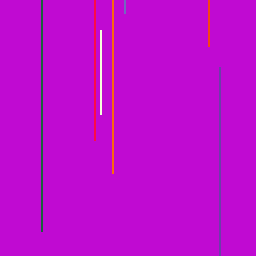

In [53]:
from torchvision import transforms
import torchvision
class_idx, class_img_idx = 0, 0
img, class_idx = class_datasets[class_idx][class_img_idx]
print(img.unsqueeze(0).shape)
t_img = transforms.ToPILImage()(img)
t_img

In [54]:
deepest_class_feature_map_conv_idx = torch.max(class_feature_map_idxs[:,1])
print(deepest_class_feature_map_conv_idx)
multi_class_rationale = get_rats.get_rationale(model, deepest_class_feature_map_conv_idx)
ClassifierNetwork = get_rats.rationale_to_classifier_network(multi_class_rationale, class_feature_map_idxs)
classifier = ClassifierNetwork()
logits = classifier(img.unsqueeze(0))
selected_classes = torch.max(logits, dim = 1).indices
print(logits)
print(selected_classes)

tensor(9)
tensor([[1.5640, 0.6754, 1.2815, 1.8420]])
tensor([3])
